# *svoboda lab / tactile navigation*

## Setup evnironment

In [9]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import json
import re
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline
from helper.plots import *
save = True

##### Setup thunder and lightning

In [4]:
from thunder import Registration
from thunder import Series
from thunder import LinearRegression
from thunder import TuningModel
from thunder import Source, SourceModel
from thunder.extraction import BasicCleaner
from thunder import Colorize
image = Colorize.image

## Setup plotting

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

## Load raw data

In [6]:
path = os.path.expanduser('~/notebooks')

In [7]:
iSession = 13
session = '%02g' % iSession

#### Load info

In [8]:
with open(os.path.join(path,'data',session,'info.json')) as infile:
    info = json.load(infile)
info['contributors'] = ', '.join(info['contributors'])
info['dimensions'] = str(info['dimensions'])
info = pd.DataFrame(info, index = [str(info['id'])])

IOError: [Errno 2] No such file or directory: '/Users/sofroniewn/notebooks/data/13/info.json'

#### Load params

In [548]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data',session,'params','covariates.csv'))

Summarize trial information

In [549]:
trialData = covariates[['trialType','trialNum']].groupby(['trialNum'], sort=True).first()
trialData = trialData.join(covariates[['speed','trialNum','corPos']].groupby(['trialNum'], sort=True).mean())
trialData.sort('trialType', inplace = True, ascending = False)

In [550]:
speedThresh = 3

####Load images

In [551]:
refConf = tsc.loadJSON(os.path.join(path,'data',session,'reference','conf.json'))
refConf['dims']
if len(refConf['dims']) == 3:
    nplanes = refConf['dims'][2]
else:
    nplanes = 1

In [552]:
images = tsc.loadImages(os.path.join(path,'data',session,'images'), inputFormat='tif', nplanes=nplanes, renumber=True)

## Perform image registration

Load reference

In [553]:
ref = tsc.loadImages(os.path.join(path,'data',session,'reference'))

Do registration

In [554]:
reg = Registration('planarcrosscorr')
reg.prepare(ref[0])
model = reg.fit(images)
trans = model.toArray()

Plot registration results

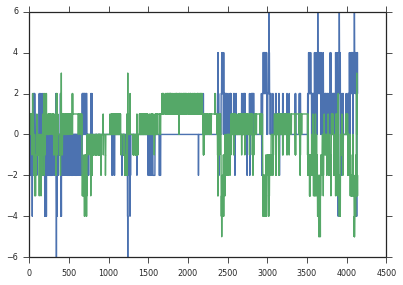

In [555]:
if nplanes > 1:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);
else:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);

Shift data and take mean

In [556]:
images = model.transform(images)
images.cache()
images.count();
mean = images.mean()

## Make local correlation

In [557]:
localCorr = images.localCorr(5)        

## Convert to series

In [558]:
series = images.toTimeSeries().squelch(50).normalize('mean')
series.cache()
series.count();

## Peform regression

Plot regressor

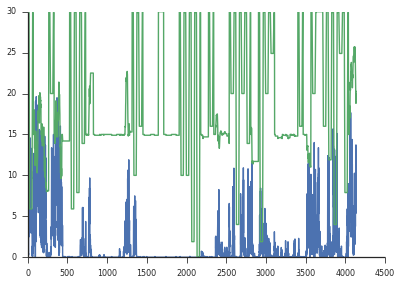

In [559]:
plt.plot(covariates.speed);
plt.plot(covariates.corPos);
sns.despine()

Peform regression

In [560]:
def buildReg(X,scale):
    maxVal = np.floor(max(X)/scale)*scale
    minVal = np.ceil(min(X)/scale)*scale
    edges = np.arange(minVal,maxVal,scale)
    edges = np.concatenate((edges, [np.Inf]))
    regMat = np.zeros([edges.shape[0]-1,X.shape[0]])
    for iEdge in range(0, edges.shape[0]-1):
        regMat[iEdge,:] = (X >= edges[iEdge]) & (X < edges[iEdge+1])
    edges = edges[:-1]
    return edges, regMat

In [561]:
regressorName = 'corPos'
pattern = re.compile('OL_.*R|OL_out')
indexOL = covariates.trialType.str.match(pattern, as_indexer=True)
mask = (covariates.itiPeriod == 0) & indexOL & (covariates.speed > speedThresh)
edges, regMat = buildReg(covariates[regressorName][mask==True].values,3)
results = LinearRegression('ordinary', intercept=False).fit(regMat.T, series.applyValues(lambda v: v[mask.values==True]))
betas = results.coeffs
rsq = results.stats.pack()
t = TuningModel.load(edges,'gaussian')
tune = t.fit(betas).select('center').pack()

## Extract source timeseries

Load sources

In [562]:
sources = tsc.loadSources(os.path.join(path,'data',session,'sources','sources.json'))

Generate source timeseries

In [563]:
tsRoiRaw = sources.transform(images, collect = False)

Calculate neuropil signal

In [564]:
# Generate source outline
outline = []
for iplane in range(1,4):
    index = np.where([x[2] == iplane for x in sources.centers])[0]
    sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
    sourcesPlane = sourcesPlane.outline(2,5).crop([0,0],[512,512])
    new = [[l+[iplane] for l in x] for x in sourcesPlane.coordinates]
    outline = outline + new
sourcesOutline = SourceModel(outline)

In [565]:
tsRoiOutlineRaw = sourcesOutline.transform(images, collect = False)

Convert to dff space and perform neuropil subtraction

Normalize and convert to table

In [566]:
tsRoi = tsRoiRaw.toTimeSeries()
tsRoi = tsRoi.normalize('window-fast',1260)
tsRoi.cache();
timeseriesRaw = pd.DataFrame(np.array(tsRoi.values().collect()))
timeseriesRaw.index.name = 'sourceId'

In [567]:
tsRoiNeuropil = tsRoiOutlineRaw.toTimeSeries()
tsRoiNeuropil = tsRoiNeuropil.normalize('window-fast',1260)
tsRoiNeuropil.cache();
timeseriesNeuropil = pd.DataFrame(np.array(tsRoiNeuropil.values().collect()))
timeseriesNeuropil.index.name = 'sourceId'

In [568]:
timeseries = timeseriesRaw - timeseriesNeuropil

##Summarize sources

In [569]:
units = pd.DataFrame(timeseries.quantile(q=0.9, axis=1),columns=['activity'])

## Perform regression on timeseries

In [570]:
def getTuningImaging(sourceId,keepInd,name,scale):
    tmp = covariates
    tmp['dff'] = timeseries.loc[sourceId]
    tmp = tmp[keepInd]
    tmp = tmp[~tmp['itiPeriod'].values.astype(bool)]
    tmp[name] = (tmp[name]/scale).round()*scale
    df = tmp[['trialNum',name,'dff']]    
    tuning, p = getTuning(df,'trialNum',name,'dff',sourceId)
    return tuning, p

In [571]:
def getTuning(df,T,X,Y,sourceId):
    df = df.groupby([T,X]).mean()
    df = df.reset_index().set_index(T)
    g = [df[df[X] == x][Y].values for x in df[X].unique()]
    f, p = f_oneway(*g)
    s = df.groupby([X])
    d = {'meanRate':s.mean()[Y].values,'stdRate':s.std()[Y].values,'numTrials':s.count().values[:,0]}
    tuning = pd.DataFrame(d).T
    tuning.columns = s.mean().index.values
    tuning['sourceId'] = sourceId
    tuning.reset_index(level=0, inplace=True)
    tuning.set_index('sourceId', inplace=True)
    tuning.rename(columns={'index':'label'}, inplace=True)
    tuning.index.name = None
    return tuning, p

In [572]:
pattern = re.compile('OL_.*R|OL_out')
indexOL = trialData.trialType.str.match(pattern, as_indexer=True)
indexRun = trialData.speed > speedThresh
trials = trialData[indexOL & indexRun]
keepInd = [x in trials.index for x in covariates.trialNum.values]
tuning = [getTuningImaging(x,keepInd,'corPos',3) for x in range(len(timeseries))]
units['pVal'] = [x[1] for x in tuning]
tuning = pd.concat([x[0] for x in tuning])

## Save summary tables

In [573]:
if save:
    np.save(os.path.join(path,'data',session,'maps','mean.npy'),mean)
    np.save(os.path.join(path,'data',session,'maps','localCorr.npy'),localCorr)
    np.save(os.path.join(path,'data',session,'maps','rsq.npy'),rsq)
    np.save(os.path.join(path,'data',session,'maps','tuning.npy'),tune)
    timeseries.to_csv(os.path.join(path,'data',session,'sources','timeseries.csv'))
    units.to_csv(os.path.join(path,'data',session,'tables','units.csv'))
    tuning.to_csv(os.path.join(path,'data',session,'tables','tuning.csv'))

#Plot maps and traces

Load maps and sources if already made

In [21]:
with open(os.path.join(path,'data',session,'info.json')) as infile:
    info = json.load(infile)
info['contributors'] = ', '.join(info['contributors'])
info['dimensions'] = str(info['dimensions'])
info = pd.DataFrame(info, index = [str(info['id'])])

In [13]:
mean = np.load(os.path.join(path,'data',session,'maps','mean.npy'))
localCorr = np.load(os.path.join(path,'data',session,'maps','localCorr.npy'))
rsq = np.load(os.path.join(path,'data',session,'maps','rsq.npy'))
tune = np.load(os.path.join(path,'data',session,'maps','tuning.npy'))
#sources = tsc.loadSources(os.path.join(path,'data',session,'sources','sources.json'))

IOError: [Errno 2] No such file or directory: '/Users/sofroniewn/notebooks/data/13/maps/mean.npy'

Load covariates and timeseries

In [14]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data',session,'params','covariates.csv'))
timeseries = pd.DataFrame.from_csv(os.path.join(path,'data',session,'sources','timeseries.csv'))

Select plane

In [ ]:
iplane = 2

#### Plot pixelwise regression map

In [10]:
pal = colormap(0)

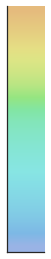

In [11]:
colorbar(pal)

In [12]:
c = Colorize(cmap=pal, scale=1, vmin=0, vmax=25)
img = c.transform(tune,background=mean.clip(min=0, max=300),mask=np.sqrt(rsq).clip(min=0.05,max=0.6),mixing=.3)
image(img[:,:,iplane])

NameError: name 'tune' is not defined

#### Plot sources

In [ ]:
index = np.where([x[2] == iplane for x in sources.centers])[0]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', base=mean[:,:,iplane].clip(0,500))
image(img)
for s in range(sourcesPlane.count):
    plt.annotate(s=str(index[s]), xy=sourcesPlane[s].center[[1,0]], color='w');

In [ ]:
index = [160, 150, 159]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', outline=False, base=mean[:,:,iplane].clip(0,500))
image(img)

####Plot timeseries

In [24]:
def plotTimeseries(x, start, stop, c, ylabel=None):
    plt.plot((covariates.index[start:stop] - covariates.index[start])/info.iloc[0]['rate-hz'], x[start:stop], c=c);
    plt.xlabel('Time (s)')
    if ylabel:
        plt.ylabel(ylabel)

Define time interval

In [25]:
start = 2664
stop = 3104

Plot wall distance trace

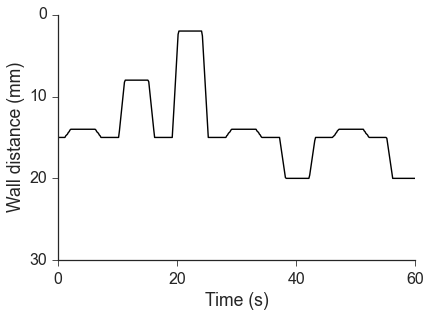

In [31]:
plotTimeseries(covariates.corPos, start, stop, c='k', ylabel='Wall distance (mm)')
plt.xlim([0, 60])
plt.ylim([0, 30])
plt.xticks(range(0,80,20))
plt.yticks(range(0,40,10))
plt.gca().invert_yaxis()
sns.despine()

Sources used in the paper are 150, 159, and 160

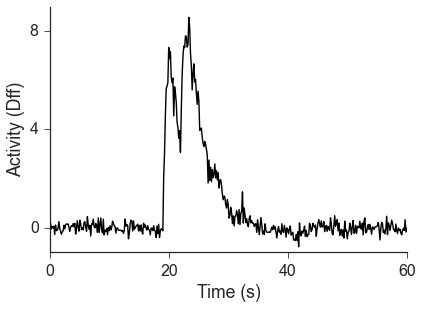

In [30]:
s = 150
plotTimeseries(timeseries.loc[s], start, stop, c='k', ylabel='Activity (Dff)')
plt.xlim([0, 60])
plt.xticks(range(0,80,20))
plt.yticks(range(0,10,4))
plt.ylim([-1, 9])
sns.despine()